In [1]:
import numpy as np
import matplotlib.cm as cm
from matplotlib import ticker
import math
import scipy
from scipy import spatial
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import dask
from sklearn.neighbors import KDTree
import netCDF4
from metpy import calc
from metpy.units import units
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats
import pandas as pd

import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs

from sklearn.cluster import KMeans
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import metrics
from scipy.ndimage import gaussian_filter
from sklearn.linear_model import LinearRegression

In [2]:
path_to_file = '/DFS-L/DATA/pritchard/gmooers/Raw_Data_Storage/MAPS/SPCAM/100_Days/New_SPCAM5/archive/TimestepOutput_Neuralnet_SPCAM_216/atm/hist/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-00000.nc'
extra_variables = xr.open_dataset(path_to_file)
latitudes = np.squeeze(extra_variables.LAT_20s_to_20n.values)
longitudes = np.squeeze(extra_variables.LON_0e_to_360e.values)
new_lons, new_lats = np.meshgrid(longitudes, latitudes)

In [3]:
lat_keys = np.arange(0,22,1)
lat_values = latitudes
lon_keys = np.arange(0,144,1)
lon_values = longitudes

In [4]:
lat_dic = dict(zip(lat_values, lat_keys))
lon_dic = dict(zip(lon_values, lon_keys))

# Qsat Code Section

In [5]:
def magnus_esat_ice(temperature):
    temperature = temperature - 273.15
    esat = 611.21*np.exp((22.587*temperature)/(temperature+273.86))

    return esat
    
def magnus_esat_water(temperature):
    temperature = temperature - 273.15
    esat = 610.94*np.exp((17.265*temperature)/(temperature+243.04))
    return esat

def MAGNUS(T):
    R = 287
    Rv = 461
    esat_water = magnus_esat_water(T)
    esat_ice = esat = magnus_esat_ice(T)
    esat_water[T < 273.15] = 0
    esat_ice[T >= 273.15] = 0
    esat = esat_ice+esat_water 
    return esat

In [6]:
def e_sat_general(temperature):
    temperature - 273.15
    esat_water = esat = (np.exp(34.494-(4924.99/(temperature+273.1))))/(temperature+105)**1.37
    esat_ice = (np.exp(43.494-(6545.8/(temperature+278.0))))/(temperature+868.0)**2
    esat_water[temperature < 0] = 0
    esat_ice[temperature >= 0] = 0
    esat = esat_ice+esat_water 
    return esat

In [7]:
def q_sat(temperature, pressure):
    top = (461./287.) * MAGNUS(temperature)
    bottom = pressure - (1 - (461./287.))*MAGNUS(temperature)
    return top / bottom

In [8]:
def geo_plot(my_array, my_lats, my_lons, title, vmin: float=None, vmax: float=None):
    if vmax == None:
        vmax = np.max(np.abs(my_array))
        vmin = -vmax
    fig, ax = plt.subplots(figsize=(25,4),subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
    contour_plot = ax.pcolormesh(my_lons, my_lats, my_array, cmap="bwr", transform=ccrs.PlateCarree(), vmax=vmax, vmin=vmin,rasterized=True)
    #plt.colorbar(contour_plot, ax=ax)
    ax.coastlines(linewidth=1.5,edgecolor='0.25') 
    ax.gridlines()
    ax.add_feature(cfeature.BORDERS,linewidth=1.5,edgecolor='0.25')
    ax.set_title(title, fontsize = fz)
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.805, 0.205, 0.01, 0.60])
    cbar = fig.colorbar(contour_plot, cax=cbar_ax)
    cbar.set_label(label=r'$\frac{mm}{day}$', fontsize=fz*1.25)
    cbar.ax.tick_params(labelsize=fz*1.25) 
    cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.yaxis.get_offset_text().set(size=fz*1.25)
    
    #plt.suptitle("+4K - 0K", y=1.02, x=0.45)

In [9]:
fz = 15*1.5
lw = 4
siz = 100
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YTEXT = 0.3 # Text placement

plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
#mpl.rcParams["font.serif"] = "STIX"
plt.rc('font', family='serif', size=fz)
matplotlib.rcParams['lines.linewidth'] = lw

In [10]:
Precip_4K = np.load("/DFS-L/DATA/pritchard/gmooers/1_14_22/Big_W_VAE_Data_With_Precip/4K_Big_Multi_Sim_Precip.npy")*60.*60.*24.*1000.
Precip_0K = np.load("/DFS-L/DATA/pritchard/gmooers/1_14_22/Big_W_VAE_Data_With_Precip/Big_Multi_Sim_Precip.npy")*60.*60.*24.*1000.
Lat_4K = np.load("/DFS-L/DATA/pritchard/gmooers/1_14_22/Big_W_VAE_Data_With_Precip/4K_Big_Multi_Sim_Lat_Test.npy")
Lon_4K = np.load("/DFS-L/DATA/pritchard/gmooers/1_14_22/Big_W_VAE_Data_With_Precip/4K_Big_Multi_Sim_Lon_Test.npy")
Lat_0K = np.load("/DFS-L/DATA/pritchard/gmooers/1_14_22/Big_W_VAE_Data_With_Precip/Big_Multi_Sim_Lat_Test.npy")
Lon_0K = np.load("/DFS-L/DATA/pritchard/gmooers/1_14_22/Big_W_VAE_Data_With_Precip/Big_Multi_Sim_Lon_Test.npy")

In [11]:
path_to_file = '/DFS-L/DATA/pritchard/gmooers/Raw_Data_Storage/Mikes_Simulations/SST_CTL_Neuralnet_SPCAM_all_Grrifin_864_ens_05/atm/hist/SST_CTL_Neuralnet_SPCAM_all_Grrifin_**.cam.h1.2009*'
extra_variables = xr.open_mfdataset(path_to_file)

T_GCM_0K = extra_variables.T_LON_0e_to_360e_LAT_20s_to_20n
P_GCM_0K = extra_variables.PS_LON_0e_to_360e_LAT_20s_to_20n

In [12]:
path_to_file = '/DFS-L/DATA/pritchard/gmooers/Raw_Data_Storage/Mikes_Simulations/SST_4Kp_Neuralnet_SPCAM_all_Grrifin_864_ens_06/atm/hist/SST_4Kp_Neuralnet_SPCAM_all_Grrifin_**.cam.h1.2009*'
extra_variables = xr.open_mfdataset(path_to_file)

T_GCM_4K = extra_variables.T_LON_0e_to_360e_LAT_20s_to_20n
P_GCM_4K = extra_variables.PS_LON_0e_to_360e_LAT_20s_to_20n

In [13]:
T_GCM_0K_sfc = T_GCM_0K[:,-1].mean(axis=0)
T_GCM_4K_sfc = T_GCM_4K[:,-1].mean(axis=0)
P_GCM_0K_sfc = P_GCM_0K.mean(axis=0)
P_GCM_4K_sfc = P_GCM_4K.mean(axis=0)

T_GCM_0K_sfc = T_GCM_0K_sfc.values
print("a")
T_GCM_4K_sfc = T_GCM_4K_sfc.values
print("b")
P_GCM_0K_sfc = P_GCM_0K_sfc.values
print("a")
P_GCM_4K_sfc = P_GCM_4K_sfc.values
print("b")

a
b
a
b


In [14]:
qsat_0K = q_sat(T_GCM_0K_sfc, P_GCM_0K_sfc)
qsat_4K = q_sat(T_GCM_4K_sfc, P_GCM_4K_sfc)

# Load In VAEs and Baselines

In [15]:
def proportion_maker(array, lats, lons, my_lat_dic, my_lon_dic):
    group_one = np.zeros(shape=(22, 144))
    group_two = np.zeros(shape=(22, 144))
    group_three = np.zeros(shape=(22, 144))
    proportion_one = np.zeros(shape=(22, 144))
    proportion_two = np.zeros(shape=(22, 144))
    proportion_three = np.zeros(shape=(22, 144))
    for i in range(len(array)):
        if array[i] == 0:
            group_one[my_lat_dic[lats[i]],my_lon_dic[lons[i]]] = group_one[my_lat_dic[lats[i]],my_lon_dic[lons[i]]] + 1
        if array[i] == 1:
            group_two[my_lat_dic[lats[i]],my_lon_dic[lons[i]]] = group_two[my_lat_dic[lats[i]],my_lon_dic[lons[i]]] + 1
        if array[i] == 2:
            group_three[my_lat_dic[lats[i]],my_lon_dic[lons[i]]] = group_three[my_lat_dic[lats[i]],my_lon_dic[lons[i]]] + 1
    
    proportion_one = group_one / (group_one + group_two + group_three)
    proportion_two = group_two / (group_one + group_two + group_three)
    proportion_three = group_three / (group_one + group_two + group_three)
    
    return proportion_one, proportion_two, proportion_three
    

In [16]:
vae_labels_4K = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/Precip_4k_Mandt_Method_3099_Z_3.npy")
vae_labels_0K = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/Precip_0K_Big_SPCAM_Labels_3099_Z_3.npy")

ww_labels_0K = np.load("Baseline_Clustering_Proportions/labels_0K_ww_3.npy")
ww_labels_4K = np.load("Baseline_Clustering_Proportions/labels_4K_ww_3.npy")

w_labels_0K = np.load("Baseline_Clustering_Proportions/labels_0K_w_field_3.npy")
w_labels_4K = np.load("Baseline_Clustering_Proportions/labels_4K_w_field_3.npy")

pca_labels_1024_0K = np.load("Baseline_Clustering_Proportions/labels_0K_pca_1024_3.npy")
pca_labels_1024_4K = np.load("Baseline_Clustering_Proportions/labels_4K_pca_1024_3.npy")

pca_labels_3_0K = np.load("Baseline_Clustering_Proportions/labels_0K_pca_3_3.npy")
pca_labels_3_4K = np.load("Baseline_Clustering_Proportions/labels_4K_pca_3_3.npy")

pca_3_0K = np.load("Baseline_Clustering_Proportions/0K_pca_3.npy")
pca_3_4K = np.load("Baseline_Clustering_Proportions/4K_pca_3.npy")

In [17]:
for i in range(3):
    print(np.count_nonzero(w_labels_4K == i), np.count_nonzero(w_labels_0K == i))

41287 44134
934895 932301
23818 23565


In [18]:
vae_proportion_0K_one, vae_proportion_0K_two, vae_proportion_0K_three = proportion_maker(vae_labels_0K, Lat_0K, Lon_0K, lat_dic, lon_dic)
vae_proportion_4K_one, vae_proportion_4K_two, vae_proportion_4K_three = proportion_maker(vae_labels_4K, Lat_4K, Lon_4K, lat_dic, lon_dic)

ww_proportion_0K_one, ww_proportion_0K_two, ww_proportion_0K_three = proportion_maker(ww_labels_0K, Lat_0K, Lon_0K, lat_dic, lon_dic)
ww_proportion_4K_one, ww_proportion_4K_two, ww_proportion_4K_three = proportion_maker(ww_labels_4K, Lat_4K, Lon_4K, lat_dic, lon_dic)

w_proportion_0K_one, w_proportion_0K_two, w_proportion_0K_three = proportion_maker(w_labels_0K, Lat_0K, Lon_0K, lat_dic, lon_dic)
w_proportion_4K_one, w_proportion_4K_two, w_proportion_4K_three = proportion_maker(w_labels_4K, Lat_4K, Lon_4K, lat_dic, lon_dic)

pca_proportion_1024_0K_one, pca_proportion_1024_0K_two, pca_proportion_1024_0K_three = proportion_maker(pca_labels_1024_0K, Lat_0K, Lon_0K, lat_dic, lon_dic)
pca_proportion_1024_4K_one, pca_proportion_1024_4K_two, pca_proportion_1024_4K_three = proportion_maker(pca_labels_1024_4K, Lat_4K, Lon_4K, lat_dic, lon_dic)

pca_proportion_3_0K_one, pca_proportion_3_0K_two, pca_proportion_3_0K_three = proportion_maker(pca_labels_3_0K, Lat_0K, Lon_0K, lat_dic, lon_dic)
pca_proportion_3_4K_one, pca_proportion_3_4K_two, pca_proportion_3_4K_three = proportion_maker(pca_labels_3_4K, Lat_4K, Lon_4K, lat_dic, lon_dic)

# Simple Model Correlaions

In [19]:
lat_lon_0K = np.zeros(shape=(22,144,500))
lat_lon_4K = np.zeros(shape=(22,144,500))
indexer_0K = np.zeros(shape=(22,144))
indexer_4K = np.zeros(shape=(22,144))
lat_lon_4K[:, :, :] = np.nan 
lat_lon_0K[:, :, :] = np.nan
count_0K = 0
count_4K = 0
for i in range(len(Precip_4K)):
    lat_lon_0K[lat_dic[Lat_0K[i]],lon_dic[Lon_0K[i]],int(indexer_0K[lat_dic[Lat_0K[i]],lon_dic[Lon_0K[i]]])] = Precip_0K[i]
    indexer_0K[lat_dic[Lat_0K[i]],lon_dic[Lon_0K[i]]] = int(indexer_0K[lat_dic[Lat_0K[i]],lon_dic[Lon_0K[i]]] + 1)
    lat_lon_4K[lat_dic[Lat_4K[i]],lon_dic[Lon_4K[i]],int(indexer_4K[lat_dic[Lat_4K[i]],lon_dic[Lon_4K[i]]])] = Precip_4K[i]
    indexer_4K[lat_dic[Lat_4K[i]],lon_dic[Lon_4K[i]]] = int(indexer_4K[lat_dic[Lat_4K[i]],lon_dic[Lon_4K[i]]] + 1)

In [20]:
P_001_0k = np.zeros(shape=(22,144))
P_01_0k = np.zeros(shape=(22,144))
P_1_0k = np.zeros(shape=(22,144))
P_5_0k = np.zeros(shape=(22,144))
P_25_0k = np.zeros(shape=(22,144))
P_50_0k = np.zeros(shape=(22,144))
P_75_0k = np.zeros(shape=(22,144))
P_90_0k = np.zeros(shape=(22,144))
P_95_0k = np.zeros(shape=(22,144))
P_99_0k = np.zeros(shape=(22,144))
P_999_0k = np.zeros(shape=(22,144))
P_9999_0k = np.zeros(shape=(22,144))

P_001_4k = np.zeros(shape=(22,144))
P_01_4k = np.zeros(shape=(22,144))
P_1_4k = np.zeros(shape=(22,144))
P_5_4k = np.zeros(shape=(22,144))
P_25_4k = np.zeros(shape=(22,144))
P_50_4k = np.zeros(shape=(22,144))
P_75_4k = np.zeros(shape=(22,144))
P_90_4k = np.zeros(shape=(22,144))
P_95_4k = np.zeros(shape=(22,144))
P_99_4k = np.zeros(shape=(22,144))
P_999_4k = np.zeros(shape=(22,144))
P_9999_4k = np.zeros(shape=(22,144))

for i in range(len(lat_lon_0K)):
    for j in range(len(lat_lon_0K[0])):
        P_001_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 0.01)
        P_01_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 0.1)
        P_1_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 1)
        P_5_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 5)
        P_25_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 25)
        P_50_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 50)
        P_75_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 75)
        P_90_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 90)
        P_95_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 95)
        P_99_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 99)
        P_999_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 99.9)
        P_9999_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 99.99)
        
        P_001_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 0.01)
        P_01_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 0.1)
        P_1_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 1)
        P_5_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 5)
        P_25_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 25)
        P_50_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 50)
        P_75_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 75)
        P_90_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 90)
        P_95_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 95)
        P_99_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 99)
        P_999_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 99.9)
        P_9999_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 99.99)

In [21]:
def lin_reg(P, q_sat, Pi_1, Pi_2, Pi_3):
    reg = LinearRegression(fit_intercept=True, normalize=False)
    y = P / q_sat 
    y_lin_reg = gaussian_filter(y, 2, mode='nearest').ravel()
    
    X = np.empty(shape=(Pi_1.size, 3))
    X[:, 0] = gaussian_filter(Pi_1, 2, mode='nearest').ravel()
    X[:, 1] = gaussian_filter(Pi_2, 2, mode='nearest').ravel()
    X[:, 2] = gaussian_filter(Pi_3, 2, mode='nearest').ravel()


    reg.fit(X, y_lin_reg)
    return reg.score(X, y_lin_reg), reg.coef_, reg.intercept_

In [22]:
def lin_reg_vae(P, q_sat, Pi_1, Pi_2):
    reg = LinearRegression(fit_intercept=True, normalize=False)
    y = P / q_sat 
    y_lin_reg = gaussian_filter(y, 2, mode='nearest').ravel()
    
    X = np.empty(shape=(Pi_1.size, 2))
    X[:, 0] = gaussian_filter(Pi_1, 2, mode='nearest').ravel()
    X[:, 1] = gaussian_filter(Pi_2, 2, mode='nearest').ravel()


    reg.fit(X, y_lin_reg)
    return reg.score(X, y_lin_reg), reg.coef_, reg.intercept_

In [23]:
y_0K_Scores_vae = [lin_reg_vae(P_001_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[0],
    lin_reg_vae(P_01_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[0],
    lin_reg_vae(P_1_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[0],
    lin_reg_vae(P_5_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[0],
    lin_reg_vae(P_25_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[0],
    lin_reg_vae(P_50_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[0],
    lin_reg_vae(P_75_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[0],
    lin_reg_vae(P_95_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[0],
    lin_reg_vae(P_99_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[0],
    lin_reg_vae(P_999_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[0],
    lin_reg_vae(P_9999_0k, qsat_0K, vae_proportion_0K_one,vae_proportion_0K_two)[0]]

y_4K_Scores_vae = [lin_reg_vae(P_001_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[0],
    lin_reg_vae(P_01_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[0],
    lin_reg_vae(P_1_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[0],
    lin_reg_vae(P_5_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[0],
    lin_reg_vae(P_25_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[0],
    lin_reg_vae(P_50_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[0],
    lin_reg_vae(P_75_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[0],
    lin_reg_vae(P_95_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[0],
    lin_reg_vae(P_99_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[0],
    lin_reg_vae(P_999_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[0],
    lin_reg_vae(P_9999_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[0]]

In [24]:
y_0K_Scores_ww = [lin_reg_vae(P_001_0k, qsat_0K, ww_proportion_0K_one, ww_proportion_0K_two)[0],
    lin_reg_vae(P_01_0k, qsat_0K, ww_proportion_0K_one, ww_proportion_0K_two)[0],
    lin_reg_vae(P_1_0k, qsat_0K, ww_proportion_0K_one, ww_proportion_0K_two)[0],
    lin_reg_vae(P_5_0k, qsat_0K, ww_proportion_0K_one, ww_proportion_0K_two)[0],
    lin_reg_vae(P_25_0k, qsat_0K, ww_proportion_0K_one, ww_proportion_0K_two)[0],
    lin_reg_vae(P_50_0k, qsat_0K, ww_proportion_0K_one, ww_proportion_0K_two)[0],
    lin_reg_vae(P_75_0k, qsat_0K, ww_proportion_0K_one, ww_proportion_0K_two)[0],
    lin_reg_vae(P_95_0k, qsat_0K, ww_proportion_0K_one, ww_proportion_0K_two)[0],
    lin_reg_vae(P_99_0k, qsat_0K, ww_proportion_0K_one, ww_proportion_0K_two)[0],
    lin_reg_vae(P_999_0k, qsat_0K, ww_proportion_0K_one, ww_proportion_0K_two)[0],
    lin_reg_vae(P_9999_0k, qsat_0K, ww_proportion_0K_one, ww_proportion_0K_two)[0]]

y_4K_Scores_ww = [lin_reg_vae(P_001_4k, qsat_4K, ww_proportion_4K_one, ww_proportion_4K_two)[0],
    lin_reg_vae(P_01_4k, qsat_4K, ww_proportion_4K_one, ww_proportion_4K_two)[0],
    lin_reg_vae(P_1_4k, qsat_4K, ww_proportion_4K_one, ww_proportion_4K_two)[0],
    lin_reg_vae(P_5_4k, qsat_4K, ww_proportion_4K_one, ww_proportion_4K_two)[0],
    lin_reg_vae(P_25_4k, qsat_4K, ww_proportion_4K_one, ww_proportion_4K_two)[0],
    lin_reg_vae(P_50_4k, qsat_4K, ww_proportion_4K_one, ww_proportion_4K_two)[0],
    lin_reg_vae(P_75_4k, qsat_4K, ww_proportion_4K_one, ww_proportion_4K_two)[0],
    lin_reg_vae(P_95_4k, qsat_4K, ww_proportion_4K_one, ww_proportion_4K_two)[0],
    lin_reg_vae(P_99_4k, qsat_4K, ww_proportion_4K_one, ww_proportion_4K_two)[0],
    lin_reg_vae(P_999_4k, qsat_4K, ww_proportion_4K_one, ww_proportion_4K_two)[0],
    lin_reg_vae(P_9999_4k, qsat_4K, ww_proportion_4K_one, ww_proportion_4K_two)[0]]

In [25]:
y_0K_Scores_w = [lin_reg(P_001_0k, qsat_0K, w_proportion_0K_one, w_proportion_0K_two, w_proportion_0K_three)[0],
    lin_reg(P_01_0k, qsat_0K, w_proportion_0K_one, w_proportion_0K_two, w_proportion_0K_three)[0],
    lin_reg(P_1_0k, qsat_0K, w_proportion_0K_one, w_proportion_0K_two, w_proportion_0K_three)[0],
    lin_reg(P_5_0k, qsat_0K, w_proportion_0K_one, w_proportion_0K_two, w_proportion_0K_three)[0],
    lin_reg(P_25_0k, qsat_0K, w_proportion_0K_one, w_proportion_0K_two, w_proportion_0K_three)[0],
    lin_reg(P_50_0k, qsat_0K, w_proportion_0K_one, w_proportion_0K_two, w_proportion_0K_three)[0],
    lin_reg(P_75_0k, qsat_0K, w_proportion_0K_one, w_proportion_0K_two, w_proportion_0K_three)[0],
    lin_reg(P_95_0k, qsat_0K, w_proportion_0K_one, w_proportion_0K_two, w_proportion_0K_three)[0],
    lin_reg(P_99_0k, qsat_0K, w_proportion_0K_one, w_proportion_0K_two, w_proportion_0K_three)[0],
    lin_reg(P_999_0k, qsat_0K, w_proportion_0K_one, w_proportion_0K_two, w_proportion_0K_three)[0],
    lin_reg(P_9999_0k, qsat_0K, w_proportion_0K_one, w_proportion_0K_two, w_proportion_0K_three)[0]]

y_4K_Scores_w = [lin_reg(P_001_4k, qsat_4K, w_proportion_4K_one, w_proportion_4K_two, w_proportion_4K_three)[0],
    lin_reg(P_01_4k, qsat_4K, w_proportion_4K_one, w_proportion_4K_two, w_proportion_4K_three)[0],
    lin_reg(P_1_4k, qsat_4K, w_proportion_4K_one, w_proportion_4K_two, w_proportion_4K_three)[0],
    lin_reg(P_5_4k, qsat_4K, w_proportion_4K_one, w_proportion_4K_two, w_proportion_4K_three)[0],
    lin_reg(P_25_4k, qsat_4K, w_proportion_4K_one, w_proportion_4K_two, w_proportion_4K_three)[0],
    lin_reg(P_50_4k, qsat_4K, w_proportion_4K_one, w_proportion_4K_two, w_proportion_4K_three)[0],
    lin_reg(P_75_4k, qsat_4K, w_proportion_4K_one, w_proportion_4K_two, w_proportion_4K_three)[0],
    lin_reg(P_95_4k, qsat_4K, w_proportion_4K_one, w_proportion_4K_two, w_proportion_4K_three)[0],
    lin_reg(P_99_4k, qsat_4K, w_proportion_4K_one, w_proportion_4K_two, w_proportion_4K_three)[0],
    lin_reg(P_999_4k, qsat_4K, w_proportion_4K_one, w_proportion_4K_two, w_proportion_4K_three)[0],
    lin_reg(P_9999_4k, qsat_4K, w_proportion_4K_one, w_proportion_4K_two, w_proportion_4K_three)[0]]

In [26]:
y_0K_Scores_pca_1024 = [lin_reg(P_001_0k, qsat_0K, pca_proportion_1024_0K_one, pca_proportion_1024_0K_two, pca_proportion_1024_0K_three)[0],
    lin_reg(P_01_0k, qsat_0K, pca_proportion_1024_0K_one, pca_proportion_1024_0K_two, pca_proportion_1024_0K_three)[0],
    lin_reg(P_1_0k, qsat_0K, pca_proportion_1024_0K_one, pca_proportion_1024_0K_two, pca_proportion_1024_0K_three)[0],
    lin_reg(P_5_0k, qsat_0K, pca_proportion_1024_0K_one, pca_proportion_1024_0K_two, pca_proportion_1024_0K_three)[0],
    lin_reg(P_25_0k, qsat_0K, pca_proportion_1024_0K_one, pca_proportion_1024_0K_two, pca_proportion_1024_0K_three)[0],
    lin_reg(P_50_0k, qsat_0K, pca_proportion_1024_0K_one, pca_proportion_1024_0K_two, pca_proportion_1024_0K_three)[0],
    lin_reg(P_75_0k, qsat_0K, pca_proportion_1024_0K_one, pca_proportion_1024_0K_two, pca_proportion_1024_0K_three)[0],
    lin_reg(P_95_0k, qsat_0K, pca_proportion_1024_0K_one, pca_proportion_1024_0K_two, pca_proportion_1024_0K_three)[0],
    lin_reg(P_99_0k, qsat_0K, pca_proportion_1024_0K_one, pca_proportion_1024_0K_two, pca_proportion_1024_0K_three)[0],
    lin_reg(P_999_0k, qsat_0K, pca_proportion_1024_0K_one, pca_proportion_1024_0K_two, pca_proportion_1024_0K_three)[0],
    lin_reg(P_9999_0k, qsat_0K, pca_proportion_1024_0K_one, pca_proportion_1024_0K_two, pca_proportion_1024_0K_three)[0]]

y_4K_Scores_pca_1024 = [lin_reg(P_001_4k, qsat_4K, pca_proportion_1024_4K_one, pca_proportion_1024_4K_two, pca_proportion_1024_4K_three)[0],
    lin_reg(P_01_4k, qsat_4K, pca_proportion_1024_4K_one, pca_proportion_1024_4K_two, pca_proportion_1024_4K_three)[0],
    lin_reg(P_1_4k, qsat_4K, pca_proportion_1024_4K_one, pca_proportion_1024_4K_two, pca_proportion_1024_4K_three)[0],
    lin_reg(P_5_4k, qsat_4K, pca_proportion_1024_4K_one, pca_proportion_1024_4K_two, pca_proportion_1024_4K_three)[0],
    lin_reg(P_25_4k, qsat_4K, pca_proportion_1024_4K_one, pca_proportion_1024_4K_two, pca_proportion_1024_4K_three)[0],
    lin_reg(P_50_4k, qsat_4K, pca_proportion_1024_4K_one, pca_proportion_1024_4K_two, pca_proportion_1024_4K_three)[0],
    lin_reg(P_75_4k, qsat_4K, pca_proportion_1024_4K_one, pca_proportion_1024_4K_two, pca_proportion_1024_4K_three)[0],
    lin_reg(P_95_4k, qsat_4K, pca_proportion_1024_4K_one, pca_proportion_1024_4K_two, pca_proportion_1024_4K_three)[0],
    lin_reg(P_99_4k, qsat_4K, pca_proportion_1024_4K_one, pca_proportion_1024_4K_two, pca_proportion_1024_4K_three)[0],
    lin_reg(P_999_4k, qsat_4K, pca_proportion_1024_4K_one, pca_proportion_1024_4K_two, pca_proportion_1024_4K_three)[0],
    lin_reg(P_9999_4k, qsat_4K, pca_proportion_1024_4K_one, pca_proportion_1024_4K_two, pca_proportion_1024_4K_three)[0]]

In [27]:
y_0K_Scores_pca_3 = [lin_reg(P_001_0k, qsat_0K, pca_proportion_3_0K_one, pca_proportion_3_0K_two, pca_proportion_3_0K_three)[0],
    lin_reg(P_01_0k, qsat_0K, pca_proportion_3_0K_one, pca_proportion_3_0K_two, pca_proportion_3_0K_three)[0],
    lin_reg(P_1_0k, qsat_0K, pca_proportion_3_0K_one, pca_proportion_3_0K_two, pca_proportion_3_0K_three)[0],
    lin_reg(P_5_0k, qsat_0K, pca_proportion_3_0K_one, pca_proportion_3_0K_two, pca_proportion_3_0K_three)[0],
    lin_reg(P_25_0k, qsat_0K, pca_proportion_3_0K_one, pca_proportion_3_0K_two, pca_proportion_3_0K_three)[0],
    lin_reg(P_50_0k, qsat_0K, pca_proportion_3_0K_one, pca_proportion_3_0K_two, pca_proportion_3_0K_three)[0],
    lin_reg(P_75_0k, qsat_0K, pca_proportion_3_0K_one, pca_proportion_3_0K_two, pca_proportion_3_0K_three)[0],
    lin_reg(P_95_0k, qsat_0K, pca_proportion_3_0K_one, pca_proportion_3_0K_two, pca_proportion_3_0K_three)[0],
    lin_reg(P_99_0k, qsat_0K, pca_proportion_3_0K_one, pca_proportion_3_0K_two, pca_proportion_3_0K_three)[0],
    lin_reg(P_999_0k, qsat_0K, pca_proportion_3_0K_one, pca_proportion_3_0K_two, pca_proportion_3_0K_three)[0],
    lin_reg(P_9999_0k, qsat_0K, pca_proportion_3_0K_one, pca_proportion_3_0K_two, pca_proportion_3_0K_three)[0]]

y_4K_Scores_pca_3 = [lin_reg(P_001_4k, qsat_4K, pca_proportion_3_4K_one, pca_proportion_3_4K_two, pca_proportion_3_4K_three)[0],
    lin_reg(P_01_4k, qsat_4K, pca_proportion_3_4K_one, pca_proportion_3_4K_two, pca_proportion_3_4K_three)[0],
    lin_reg(P_1_4k, qsat_4K, pca_proportion_3_4K_one, pca_proportion_3_4K_two, pca_proportion_3_4K_three)[0],
    lin_reg(P_5_4k, qsat_4K, pca_proportion_3_4K_one, pca_proportion_3_4K_two, pca_proportion_3_4K_three)[0],
    lin_reg(P_25_4k, qsat_4K, pca_proportion_3_4K_one, pca_proportion_3_4K_two, pca_proportion_3_4K_three)[0],
    lin_reg(P_50_4k, qsat_4K, pca_proportion_3_4K_one, pca_proportion_3_4K_two, pca_proportion_3_4K_three)[0],
    lin_reg(P_75_4k, qsat_4K, pca_proportion_3_4K_one, pca_proportion_3_4K_two, pca_proportion_3_4K_three)[0],
    lin_reg(P_95_4k, qsat_4K, pca_proportion_3_4K_one, pca_proportion_3_4K_two, pca_proportion_3_4K_three)[0],
    lin_reg(P_99_4k, qsat_4K, pca_proportion_3_4K_one, pca_proportion_3_4K_two, pca_proportion_3_4K_three)[0],
    lin_reg(P_999_4k, qsat_4K, pca_proportion_3_4K_one, pca_proportion_3_4K_two, pca_proportion_3_4K_three)[0],
    lin_reg(P_9999_4k, qsat_4K, pca_proportion_3_4K_one, pca_proportion_3_4K_two, pca_proportion_3_4K_three)[0]]

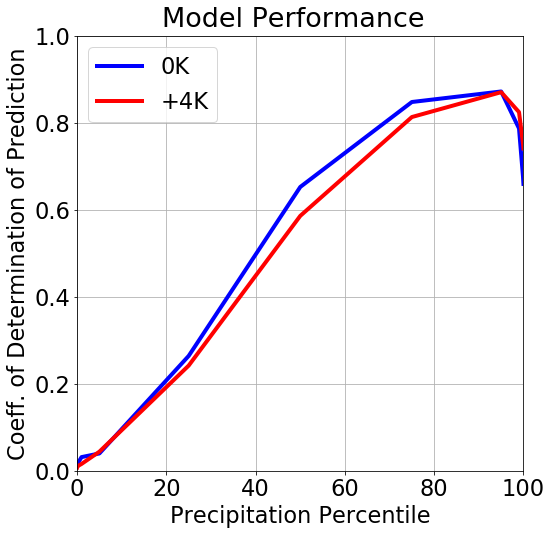

In [29]:
x = [0.01, 0.1, 1, 5, 25, 50, 75, 95, 99, 99.9, 99.99]
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlabel("Precipitation Percentile")
ax.set_ylim(0, 1)
ax.set_ylabel("Coeff. of Determination of Prediction")
ax.plot(x, y_0K_Scores_vae, linewidth=4, color="blue", label="0K")
ax.plot(x, y_4K_Scores_vae, linewidth=4, color="red", label="+4K")
ax.legend()
ax.grid()
plt.suptitle("Model Performance", y=0.93)
ax.set_xlim(0,100)
plt.savefig("Figures/Model_Performance.png", bbox_inches='tight',pad_inches = 0.1)
plt.savefig("Figures/Model_Performance.pdf", bbox_inches='tight',pad_inches = 0.1)